# Data 620 - Final Project

Baron Curtin, Heather Geiger

RNA sequencing has been a valuable tool in genetics research for well over a decade now. By looking at RNA, one can look at which genes are expressed in addition to just looking at genetic variation.

More recently, RNA sequencing at the single cell level rather than just of the whole tissue lets you see which genes are expressed in subsets of a tissue or particular cell types. Popular applications include development, neurology, autoimmune disease, and oncology.

In our final project, we plan to use automated data analysis to get a broad overview of the published research on single-cell RNA sequencing. Specifically, we plan to focus on two aspects of this. 

The first aspect will be to get a sense of the most influential authors in this field, and the relationships between them. To do this, we will run a network analysis, where connections are defined by authors being on the same paper together. 

The second aspect will be to get a sense of recurrent themes in the literature through text mining. Here, we will focus on recurrent terms in the abstracts to do this. Since the abstract of a paper is meant to provide a summary of the most important themes in a single paragraph or two, text mining these should provide a lot of information despite only needing to process a relatively small amount of text.

Our analysis will expand upon the code and algorithms used here by author Maximillian Straub: [Medium Article](https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547). We have already tried running his code to get the number of publications found from PubMed using the keyword ‘single cell rna sequencing’, and as of 12/01/19 it was 17,782. This is somewhat more than the 5,059 processed in this post, but should still be a reasonably small enough number to perform similar analysis. 

The big difference between his work and ours is that we will add text mining of the abstracts to summarize recurrent themes in the literature, rather than simply using the keywords attached to the papers in PubMed. Another difference is that one of the authors of this project (Heather Geiger) works in bioinformatics, and so already has some hypotheses about what the results here will include.  

For the text mining, one hypothesis is that the term ‘immune’ is likely to come up somewhere as part of the set of recurrent terms within the abstracts. This term is relevant to two of the common applications of single-cell RNA-Seq (autoimmune disease and cancer). Also many tools for both the lab and computational analysis use a mix of known immune cell types (from blood) as a validation dataset. So this term may come up even in papers that do not directly relate to immunology.

For the network analysis, it is difficult to predict which authors will be connected in a network based solely on shared authorship. A network based on citations might have authors of important techniques used widely in the field at its center. However, it is possible to be widely cited without being central in this network, as some of the most widely cited research could involve just one paper with relatively few authors. Therefore, we do not have any real hypotheses on what this network will look like.

In [1]:
# standard imports
import pickle
import gzip
from collections import Counter
from pathlib import Path

# third party imports
import nltk
from nltk.util import ngrams
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize, regexp_tokenize

from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot

# stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hmgeiger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data

We have already run some code to pull the records matching our search term from Pubmed.

That code is available here:

https://github.com/heathergeiger/Data620_final_project/blob/master/data620_final_project_fetch_publications.py

The lists from this code are available in the following Pickle files (split into two halves to meet file size requirements):

https://raw.githubusercontent.com/heathergeiger/Data620_final_project/master/single_cell_rna_sequencing_entrez_fetch_record_list_first_half.pkl.gz
https://raw.githubusercontent.com/heathergeiger/Data620_final_project/master/single_cell_rna_sequencing_entrez_fetch_record_list_second_half.pkl.gz

Here they have already been downloaded to a "data" folder under the current working directory.

Lets load our data and perform some EDA to get a feel for our data.

In [2]:
# load data
data_paths = (Path.cwd() / 'data').glob('*half*.gz')

def parse_data(data_path):
    with gzip.open(data_path, 'rb') as pf:
        loaded_data = pickle.load(pf)
    return loaded_data

data = [x for dp in data_paths for x in parse_data(dp)]
df = pd.DataFrame(data)

## Basic Analysis

We can perform some basic exploratory analysis to better understand the data we are working with

In [3]:
df.shape

(17807, 68)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17807 entries, 0 to 17806
Data columns (total 68 columns):
AB      17684 non-null object
AD      16719 non-null object
AID     16026 non-null object
AU      17798 non-null object
AUID    1490 non-null object
BTI     1 non-null object
CDAT    1 non-null object
CI      3252 non-null object
CIN     559 non-null object
CN      108 non-null object
COIS    429 non-null object
CON     49 non-null object
CP      1 non-null object
CRDT    17806 non-null object
DA      1 non-null object
DCOM    16707 non-null object
DEP     7825 non-null object
DP      17807 non-null object
ED      1 non-null object
EDAT    17807 non-null object
EFR     7 non-null object
EIN     352 non-null object
FAU     17798 non-null object
FED     1 non-null object
FIR     48 non-null object
GN      9 non-null object
GR      6496 non-null object
GS      613 non-null object
IP      15975 non-null object
IR      48 non-null object
IRAD    7 non-null object
IS      17797 non-nu

In [5]:
df.head()


,AB,AD,AID,AU,AUID,BTI,CDAT,CI,CIN,CN,...,RN,SB,SFM,SI,SO,STAT,TA,TI,TT,VI
0,Amino acid substitutions are commonly found in...,"[University of Washington., University of Wash...","[genetics.119.302929 [pii], 10.1534/genetics.1...","[Zhou W, Dorrity MW, Bubb KL, Queitsch C, Fiel...",NaN,NaN,NaN,"[Copyright (c) 2019, Genetics.]",NaN,NaN,...,NaN,IM,NaN,NaN,Genetics. 2019 Dec 6. pii: genetics.119.302929...,Publisher,Genetics,Binding and Regulation of Transcription by Yea...,NaN,NaN
1,"Although CD4(+) T cell ""help"" is crucial to su...","[Blood Research Institute, BloodCenter of Wisc...","[S1074-7613(19)30453-4 [pii], 10.1016/j.immuni...","[Zander R, Schauder D, Xin G, Nguyen C, Wu X, ...",NaN,NaN,NaN,[Copyright (c) 2019 Elsevier Inc. All rights r...,NaN,NaN,...,NaN,IM,NaN,NaN,Immunity. 2019 Nov 27. pii: S1074-7613(19)3045...,Publisher,Immunity,CD4(+) T Cell Help Is Required for the Formati...,NaN,NaN
2,BACKGROUND: Administration of human mesenchyma...,"[Department of Surgery, University of Michigan...",[10.1097/TA.0000000000002563 [doi]],"[Williams AM, Bhatti UF, Brown JF, Biesterveld...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AIM IM,NaN,NaN,J Trauma Acute Care Surg. 2019 Dec 5. doi: 10....,Publisher,J Trauma Acute Care Surg,Early Single-Dose Treatment with Exosomes Prov...,NaN,NaN
3,Single-cell RNA sequencing (scRNA-seq) is a po...,"[Institute of Hepatology, National Clinical Re...",[10.1002/JLB.5MR1019-179R [doi]],"[Xu G, Liu Y, Li H, Liu L, Zhang S, Zhang Z]",[ORCID: https://orcid.org/0000-0002-3544-1389],NaN,NaN,[(c)2019 Society for Leukocyte Biology.],NaN,NaN,...,NaN,IM,NaN,NaN,J Leukoc Biol. 2019 Dec 4. doi: 10.1002/JLB.5M...,Publisher,J Leukoc Biol,Dissecting the human immune system with single...,NaN,NaN
4,Resident tissue macrophages (RTMs) are cells w...,"[Singapore Immunology Network (SIgN), Agency f...",[10.3389/fimmu.2019.02694 [doi]],"[Bleriot C, Ginhoux F]",NaN,NaN,NaN,[Copyright (c) 2019 Bleriot and Ginhoux.],NaN,NaN,...,NaN,IM,NaN,NaN,Front Immunol. 2019 Nov 19;10:2694. doi: 10.33...,In-Data-Review,Front Immunol,Understanding the Heterogeneity of Resident Li...,NaN,10


## Feature Extraction

From the basic exploration, we are able to determine that there are various features we can create and features that we do
not need for our analysis.

Lets create some features from our data to make analysis a bit easier and go into our secondary EDA. Some features we might
look to create are separating the year from the data column, possibly separating each time interval from the date column, and
isolating our authors so that we have one author per line

In [6]:
# remove columns not needed for analysis
df = df[['PMID', 'FAU', 'AB', 'EDAT', 'TA', 'OT']]

# rename columns for explicitness
df.columns = ['KEY', 'AUTHORS', 'ABSTRACT', 'DATE', 'TITLE', 'KEYWORDS']
df.head()

,KEY,AUTHORS,ABSTRACT,DATE,TITLE,KEYWORDS
0,31810988,"[Zhou, Wei, Dorrity, Michael W, Bubb, Kerry L,...",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p..."
1,31810883,"[Zander, Ryan, Schauder, David, Xin, Gang, Ngu...","Although CD4(+) T cell ""help"" is crucial to su...",2019/12/08 06:00,Immunity,"[CD4(+) T cell help, CD8(+) T cell heterogenei..."
2,31804413,"[Williams, Aaron M, Bhatti, Umar F, Brown, Jor...",BACKGROUND: Administration of human mesenchyma...,2019/12/06 06:00,J Trauma Acute Care Surg,NaN
3,31803960,"[Xu, Gang, Liu, Yang, Li, Hanjie, Liu, Lei, Zh...",Single-cell RNA sequencing (scRNA-seq) is a po...,2019/12/06 06:00,J Leukoc Biol,"[cell type identification, human immune system..."
4,31803196,"[Bleriot, Camille, Ginhoux, Florent]",Resident tissue macrophages (RTMs) are cells w...,2019/12/06 06:00,Front Immunol,"[heterogeneity, liver, macrophage, monocyte, s..."


In [7]:
# create separate date columns
df['DATE_'] = pd.to_datetime(df['DATE'], infer_datetime_format=True)

# create year, month, day columns
df['YEAR'] = df['DATE_'].dt.year
df['MONTH'] = df['DATE_'].dt.month
df['DAY'] = df['DATE_'].dt.day
df['TIME'] = df['DATE_'].dt.time

In [8]:
# create ngram
df['MONOGRAMS'] = df['ABSTRACT'].fillna('?').str.lower().str.split(' ')
df['BIGRAMS'] = df['ABSTRACT'].fillna('?').str.lower().str.split(' ').apply(lambda x: list(ngrams(x, 2)))
df['TRIGRAMS'] = df['ABSTRACT'].fillna('?').str.lower().str.split(' ').apply(lambda x: list(ngrams(x, 3)))

In [9]:
# create new dataframe based on authors
x_df = pd.DataFrame(df.AUTHORS.fillna('??????').str.join('|').str.split('|').tolist(), index=df.KEY).stack()
x_df = x_df.reset_index([0, 'KEY'])
x_df.columns = ['KEY', 'AUTHOR']

# join original data back to the new df
x_df = x_df.merge(df.drop(columns=['AUTHORS']), on=['KEY'])
x_df.head()

,KEY,AUTHOR,ABSTRACT,DATE,TITLE,KEYWORDS,DATE_,YEAR,MONTH,DAY,TIME,MONOGRAMS,BIGRAMS,TRIGRAMS
0,31810988,"Zhou, Wei",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00,"[amino, acid, substitutions, are, commonly, fo...","[(amino, acid), (acid, substitutions), (substi...","[(amino, acid, substitutions), (acid, substitu..."
1,31810988,"Dorrity, Michael W",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00,"[amino, acid, substitutions, are, commonly, fo...","[(amino, acid), (acid, substitutions), (substi...","[(amino, acid, substitutions), (acid, substitu..."
2,31810988,"Bubb, Kerry L",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00,"[amino, acid, substitutions, are, commonly, fo...","[(amino, acid), (acid, substitutions), (substi...","[(amino, acid, substitutions), (acid, substitu..."
3,31810988,"Queitsch, Christine",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00,"[amino, acid, substitutions, are, commonly, fo...","[(amino, acid), (acid, substitutions), (substi...","[(amino, acid, substitutions), (acid, substitu..."
4,31810988,"Fields, Stanley",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00,"[amino, acid, substitutions, are, commonly, fo...","[(amino, acid), (acid, substitutions), (substi...","[(amino, acid, substitutions), (acid, substitu..."


In [10]:
# join keywords in a single list
x_df['KEYWORDS_MERGED'] = x_df['KEYWORDS'].str.join('|')

In [11]:
## Data Analysis/Visualization
plt.figure(figsize=(20, 20), dpi=600)

# top 10 authors
plt.subplot(2, 2, 1)
top10authors = pd.DataFrame.from_records(Counter(x_df[x_df['AUTHOR'] != '?']['AUTHOR']).most_common(10), columns=['NAME', 'COUNT'])
sns.barplot(x='COUNT', y='NAME', data=top10authors)
plt.title('Top 10 Authors')

# publications over time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(df['YEAR'].value_counts().reset_index())
yearly.columns = ['YEAR', 'COUNT']
sns.lineplot(x='YEAR', y='COUNT', data=yearly)
plt.title('Publications Over Time')
plt.xlim([df.YEAR.min(), df.YEAR.max()])

# top 10 journals
plt.subplot(2, 2, 3)
top10journals = pd.DataFrame.from_records(Counter(df['TITLE']).most_common(10), columns=['TITLE', 'COUNT'])
sns.barplot(x='COUNT', y='TITLE', data=top10journals)
plt.title('Top 10 Journals')

# top 10 keywords
plt.subplot(2, 2, 4)
keywords = df['KEYWORDS'].dropna().str.join('|').str.split('|').tolist()
flat_kws = [_.lower() for kw in keywords
            for _ in kw]
top10kw = pd.DataFrame.from_records(Counter(flat_kws).most_common(10), columns=['KEYWORD', 'COUNT'])
sns.barplot(x='COUNT', y='KEYWORD', data=top10kw)
plt.title('Top 10 Keywords')

<Figure size 12000x12000 with 0 Axes>

Text(0.5, 1.0, 'Top 10 Authors')

Text(0.5, 1.0, 'Publications Over Time')

(1971, 2019)

Text(0.5, 1.0, 'Top 10 Journals')

Text(0.5, 1.0, 'Top 10 Keywords')

We see the number of publications really explode over the past decade with the rise of various techniques allowing higher and higher throughput in terms of the number of molecules and cells that can be sequenced.

Let's actually redo this analysis looking only at publications from the past decade (2010 or later).

In [16]:
df = df[df['YEAR'] >= 2010]

# create ngram
df['MONOGRAMS'] = df['ABSTRACT'].fillna('?').str.lower().str.split(' ')
df['BIGRAMS'] = df['ABSTRACT'].fillna('?').str.lower().str.split(' ').apply(lambda x: list(ngrams(x, 2)))
df['TRIGRAMS'] = df['ABSTRACT'].fillna('?').str.lower().str.split(' ').apply(lambda x: list(ngrams(x, 3)))

# create new dataframe based on authors
x_df = pd.DataFrame(df.AUTHORS.fillna('??????').str.join('|').str.split('|').tolist(), index=df.KEY).stack()
x_df = x_df.reset_index([0, 'KEY'])
x_df.columns = ['KEY', 'AUTHOR']

# join original data back to the new df
x_df = x_df.merge(df.drop(columns=['AUTHORS']), on=['KEY'])

# join keywords in a single list
x_df['KEYWORDS_MERGED'] = x_df['KEYWORDS'].str.join('|')

In [17]:
## Data Analysis/Visualization


# top 10 authors
plt.subplot(2, 2, 1)
top10authors = pd.DataFrame.from_records(Counter(x_df[x_df['AUTHOR'] != '?']['AUTHOR']).most_common(10), columns=['NAME', 'COUNT'])
sns.barplot(x='COUNT', y='NAME', data=top10authors)
plt.title('Top 10 Authors')

# publications over time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(df['YEAR'].value_counts().reset_index())
yearly.columns = ['YEAR', 'COUNT']
sns.lineplot(x='YEAR', y='COUNT', data=yearly)
plt.title('Publications Over Time')
plt.xlim([df.YEAR.min(), df.YEAR.max()])

# top 10 journals
plt.subplot(2, 2, 3)
top10journals = pd.DataFrame.from_records(Counter(df['TITLE']).most_common(10), columns=['TITLE', 'COUNT'])
sns.barplot(x='COUNT', y='TITLE', data=top10journals)
plt.title('Top 10 Journals')

# top 10 keywords
plt.subplot(2, 2, 4)
keywords = df['KEYWORDS'].dropna().str.join('|').str.split('|').tolist()
flat_kws = [_.lower() for kw in keywords
            for _ in kw]
top10kw = pd.DataFrame.from_records(Counter(flat_kws).most_common(10), columns=['KEYWORD', 'COUNT'])
sns.barplot(x='COUNT', y='KEYWORD', data=top10kw)
plt.title('Top 10 Keywords')

<Figure size 12000x12000 with 0 Axes>

Text(0.5, 1.0, 'Top 10 Authors')

Text(0.5, 1.0, 'Publications Over Time')

(2010, 2019)

Text(0.5, 1.0, 'Top 10 Journals')

Text(0.5, 1.0, 'Top 10 Keywords')

Top authors have published anywhere from 20-50 papers on this topic over the past decade. 

Our top journal list subsetting to 2010 and after looks quite different from before. Presumably many of the publications from "J Biol Chem" and a few others were from 2009 or before.

Our keyword list is not very informative. Most of the top results are just variations of the search term. While "transcriptome" and "gene expression" are just synonyms for RNA profile. This highlights the importance of looking at the abstracts to get a better understanding of the data. 

So now, let's look at some of the top single words (monograms) and bigrams/trigrams (2-3 word phrases) in the abstracts.

## Text mining abstracts

In [22]:
#Get a data frame with one line per combination of word/phrase and article.
#Run separately for monograms, bigrams, and trigrams.

def process_ngrams(df_, col_name):
    new_df = pd.DataFrame(df_.copy()[col_name].tolist(), index=df_.copy().KEY).stack()
    new_df = new_df.reset_index([0, 'KEY'])
    new_df.columns = ['KEY', col_name]    
    new_df = new_df.merge(df_.copy().drop(columns=col_name), on=['KEY'])
    
     # process tuples into strings
    if col_name != 'MONOGRAMS':
        new_df[col_name] = new_df[col_name].str.join('|')
    
    return new_df

monograms_df = process_ngrams(df, 'MONOGRAMS')
bigrams_df = process_ngrams(df, 'BIGRAMS')
trigrams_df = process_ngrams(df, 'TRIGRAMS')

In [23]:
# get top n counts
def get_top_n_counts(df_, col_name, n=50):
    new_df = df_.copy()
    
    # remove stop words
    if col_name == 'MONOGRAMS':
        new_df = new_df[~new_df['MONOGRAMS'].isin(stop_words)]
    
    new_df = new_df[col_name].value_counts().reset_index(name='COUNT')
    new_df.columns = ['TOKENS', 'COUNT']
    new_df = new_df.sort_values(by=['COUNT'], ascending=[False])
        
    # get top n
    new_df = new_df.head(n)
    return new_df

top_n_monograms = get_top_n_counts(monograms_df, 'MONOGRAMS')
top_n_bigrams = get_top_n_counts(bigrams_df, 'BIGRAMS')
top_n_trigrams = get_top_n_counts(trigrams_df, 'TRIGRAMS')

<Figure size 600x1200 with 0 Axes>

Text(0.5, 1.0, 'Top 50 words in abstracts')

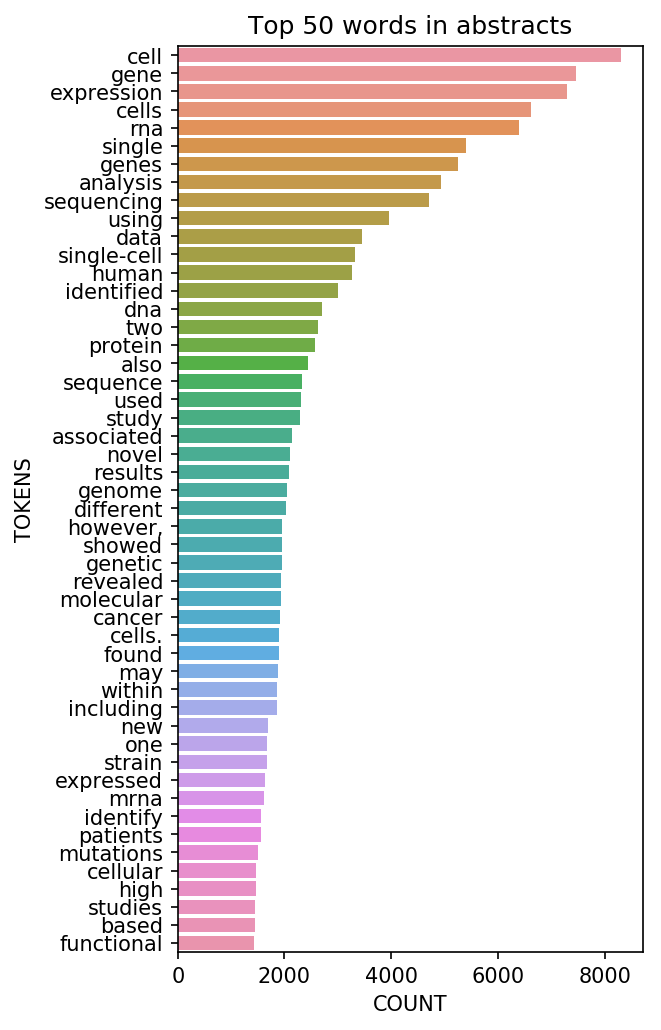

In [33]:
plt.figure(figsize=(4, 8), dpi=150)
sns.barplot(y='TOKENS', x='COUNT', data=top_n_monograms)
plt.title('Top 50 words in abstracts')

We find the very top most frequent single words are not very interesting, similar to the keywords. However as we scroll down we start to see some words of interest. For example, we find "cancer" within the top 50 most common abstract words, which corresponds to the idea of single-cell RNA sequencing being frequently applied to study cancer. We also find the term "mutations" and "functional", suggesting that scRNA-Seq may be used to study the functional consequences of genetic mutations.

Finally, we find a lot of general science-related terms such as "associated" and "results". I imagine these terms would also be found frequently in a corpus describing scientific research on a completely different topic.

Let's go up to getting the top 1000 words in abstracts, so we can see if we find our hypothesis word "immune" and where on the list it falls.

In [34]:
top_n_monograms_long = get_top_n_counts(monograms_df,'MONOGRAMS',n=1000)

In [35]:
top_n_monograms_long[top_n_monograms_long['TOKENS'] == "immune"]

,TOKENS,COUNT
111,immune,990


In [38]:
top_n_monograms_long[top_n_monograms_long['TOKENS'] == "results"]

,TOKENS,COUNT
23,results,2078


The term "immune" is ranked 112 on our list, found 990 times. While 112 may not seem super high, consider that this term was found only a bit less than half as often as "results" (found 2078 times). By comparison to such a general term, it seems quite significant that we find it so often! 

Let's move on now to look at two-word and three-word phrases.

<Figure size 600x1200 with 0 Axes>

Text(0.5, 1.0, 'Top 50 two-word phrases in abstracts')

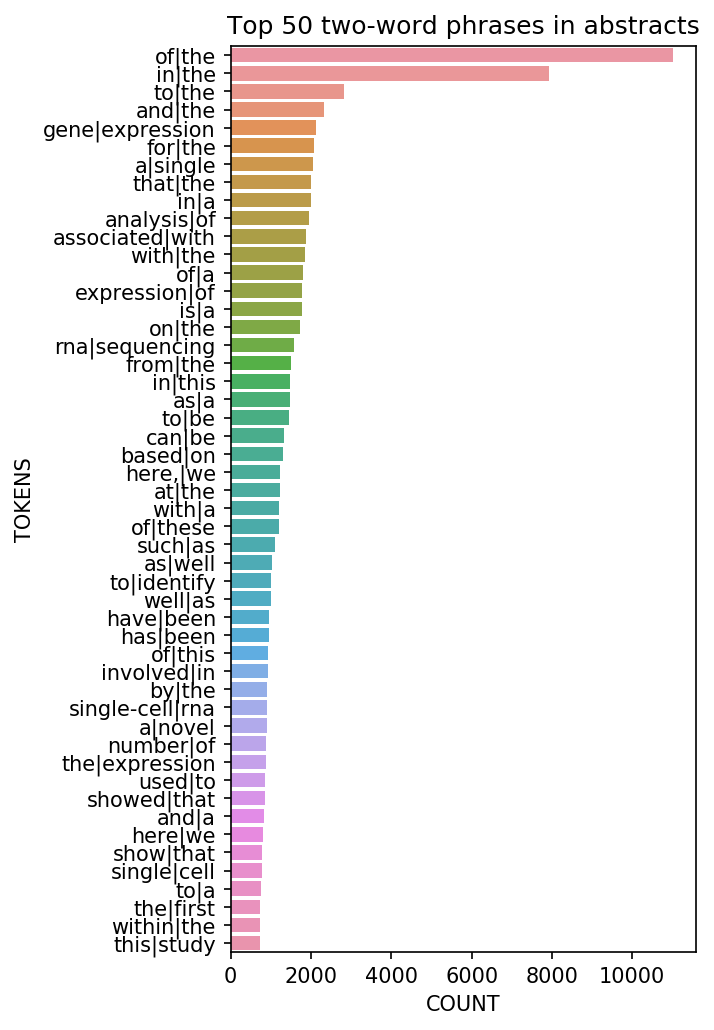

In [39]:
plt.figure(figsize=(4, 8), dpi=150)
sns.barplot(y='TOKENS', x='COUNT', data=top_n_bigrams)
plt.title('Top 50 two-word phrases in abstracts')

<Figure size 600x1200 with 0 Axes>

Text(0.5, 1.0, 'Top 50 three-word phrases in abstracts')

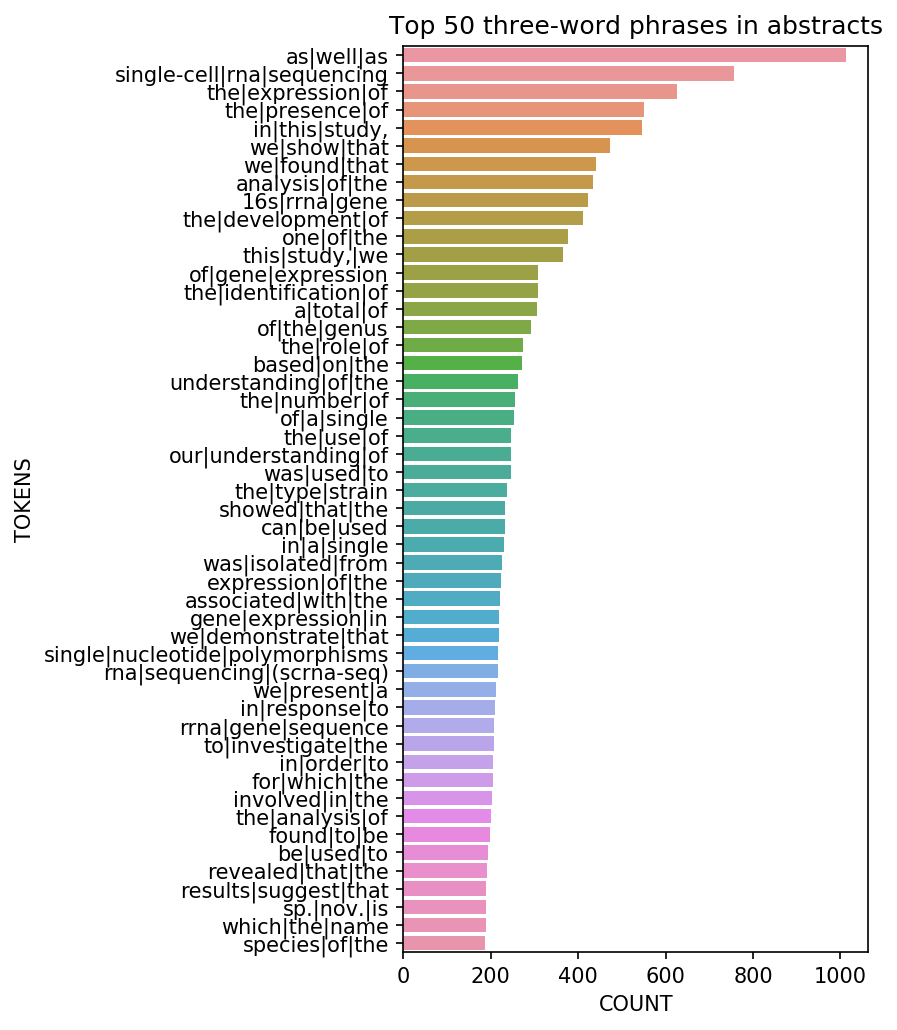

In [40]:
plt.figure(figsize=(4, 8), dpi=150)
sns.barplot(y='TOKENS', x='COUNT', data=top_n_trigrams)
plt.title('Top 50 three-word phrases in abstracts')

The two-word phrases are dominated by stop words, which were only removed for the monograms but not the bigrams and trigrams. Therefore this list does not appear to reveal much of interest.

Meanwhile the three-word phrases actually show some very interesting hits by comparison. For example, "16S rRNA gene" suggests that many of these publications involve looking at bacterial taxonomy (https://doi.org/10.1054/modi.2001.29158). We also find that while "development" did not crack the top 50 for top single words, the phrase "the development of" is near the top for three-word phrases. This reveals that development is a popular application for single-cell RNA sequencing, as we might have expected.

## Network analysis of authors

We move on now to our network analysis of authors.

### Network build and visualize

In [60]:
# Extract author connections
authors = df["AUTHORS"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
connection_df = pd.DataFrame(flat_connections, columns=["From", "To"])
connection_graph = connection_df.groupby(["From", "To"]).size().reset_index()
connection_graph.columns = ["From", "To", "Count"]

#Build network graph.
G = nx.from_pandas_edgelist(
    connection_graph, source="From", target="To", edge_attr="Count"
)

In [61]:
# Limit to TOP 50 authors

top50authors = pd.DataFrame.from_records(
    Counter(x_df[x_df['AUTHOR'] != '?']['AUTHOR']).most_common(50), columns=['NAME', 'COUNT'])

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["NAME"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.node[n]["publications"] = int(
        top50authors[top50authors["NAME"] == n]["COUNT"]
    )

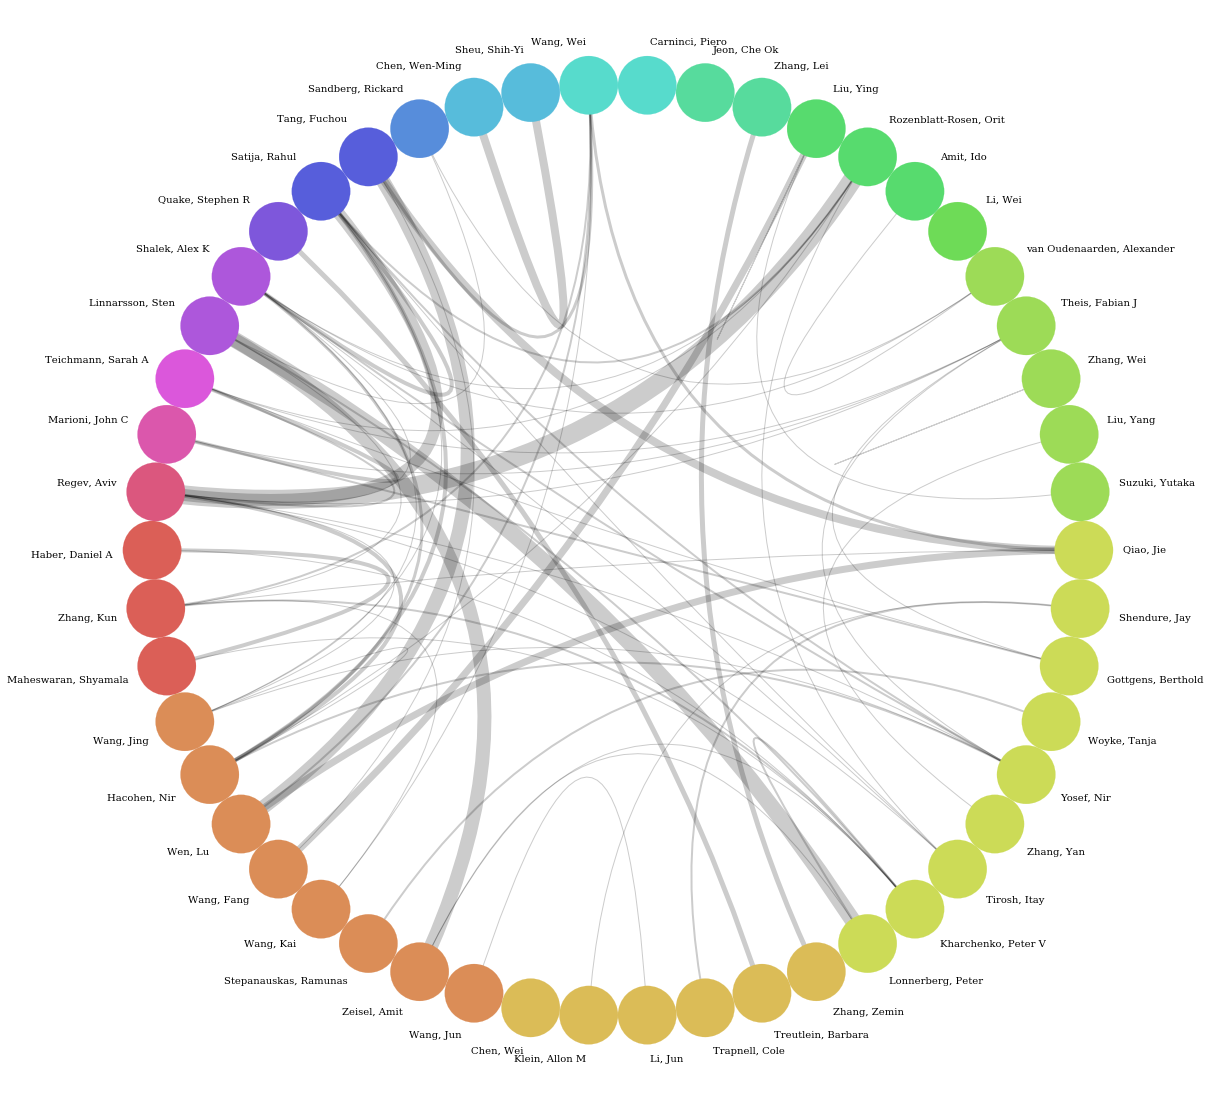

In [66]:
c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

We find several instances where one pair of authors will have published a number of papers together. We also generally find more connections than were found in the analysis using keyword "optical trap" in the Medium post, suggesting that this field tends to involve more collaborative work and more authors per paper than some other scientific fields.

### Quantitative analysis of the network (centrality measures)

In [69]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

In [78]:
pubs_per_author = dict(zip(top50authors['NAME'].tolist(),top50authors['COUNT'].tolist()))

In [86]:
top_df = pd.DataFrame.from_dict(
    [deg, bet, pubs_per_author]).T

Text(0.5, 1.0, 'Top 10 Authors, normalized parameters')

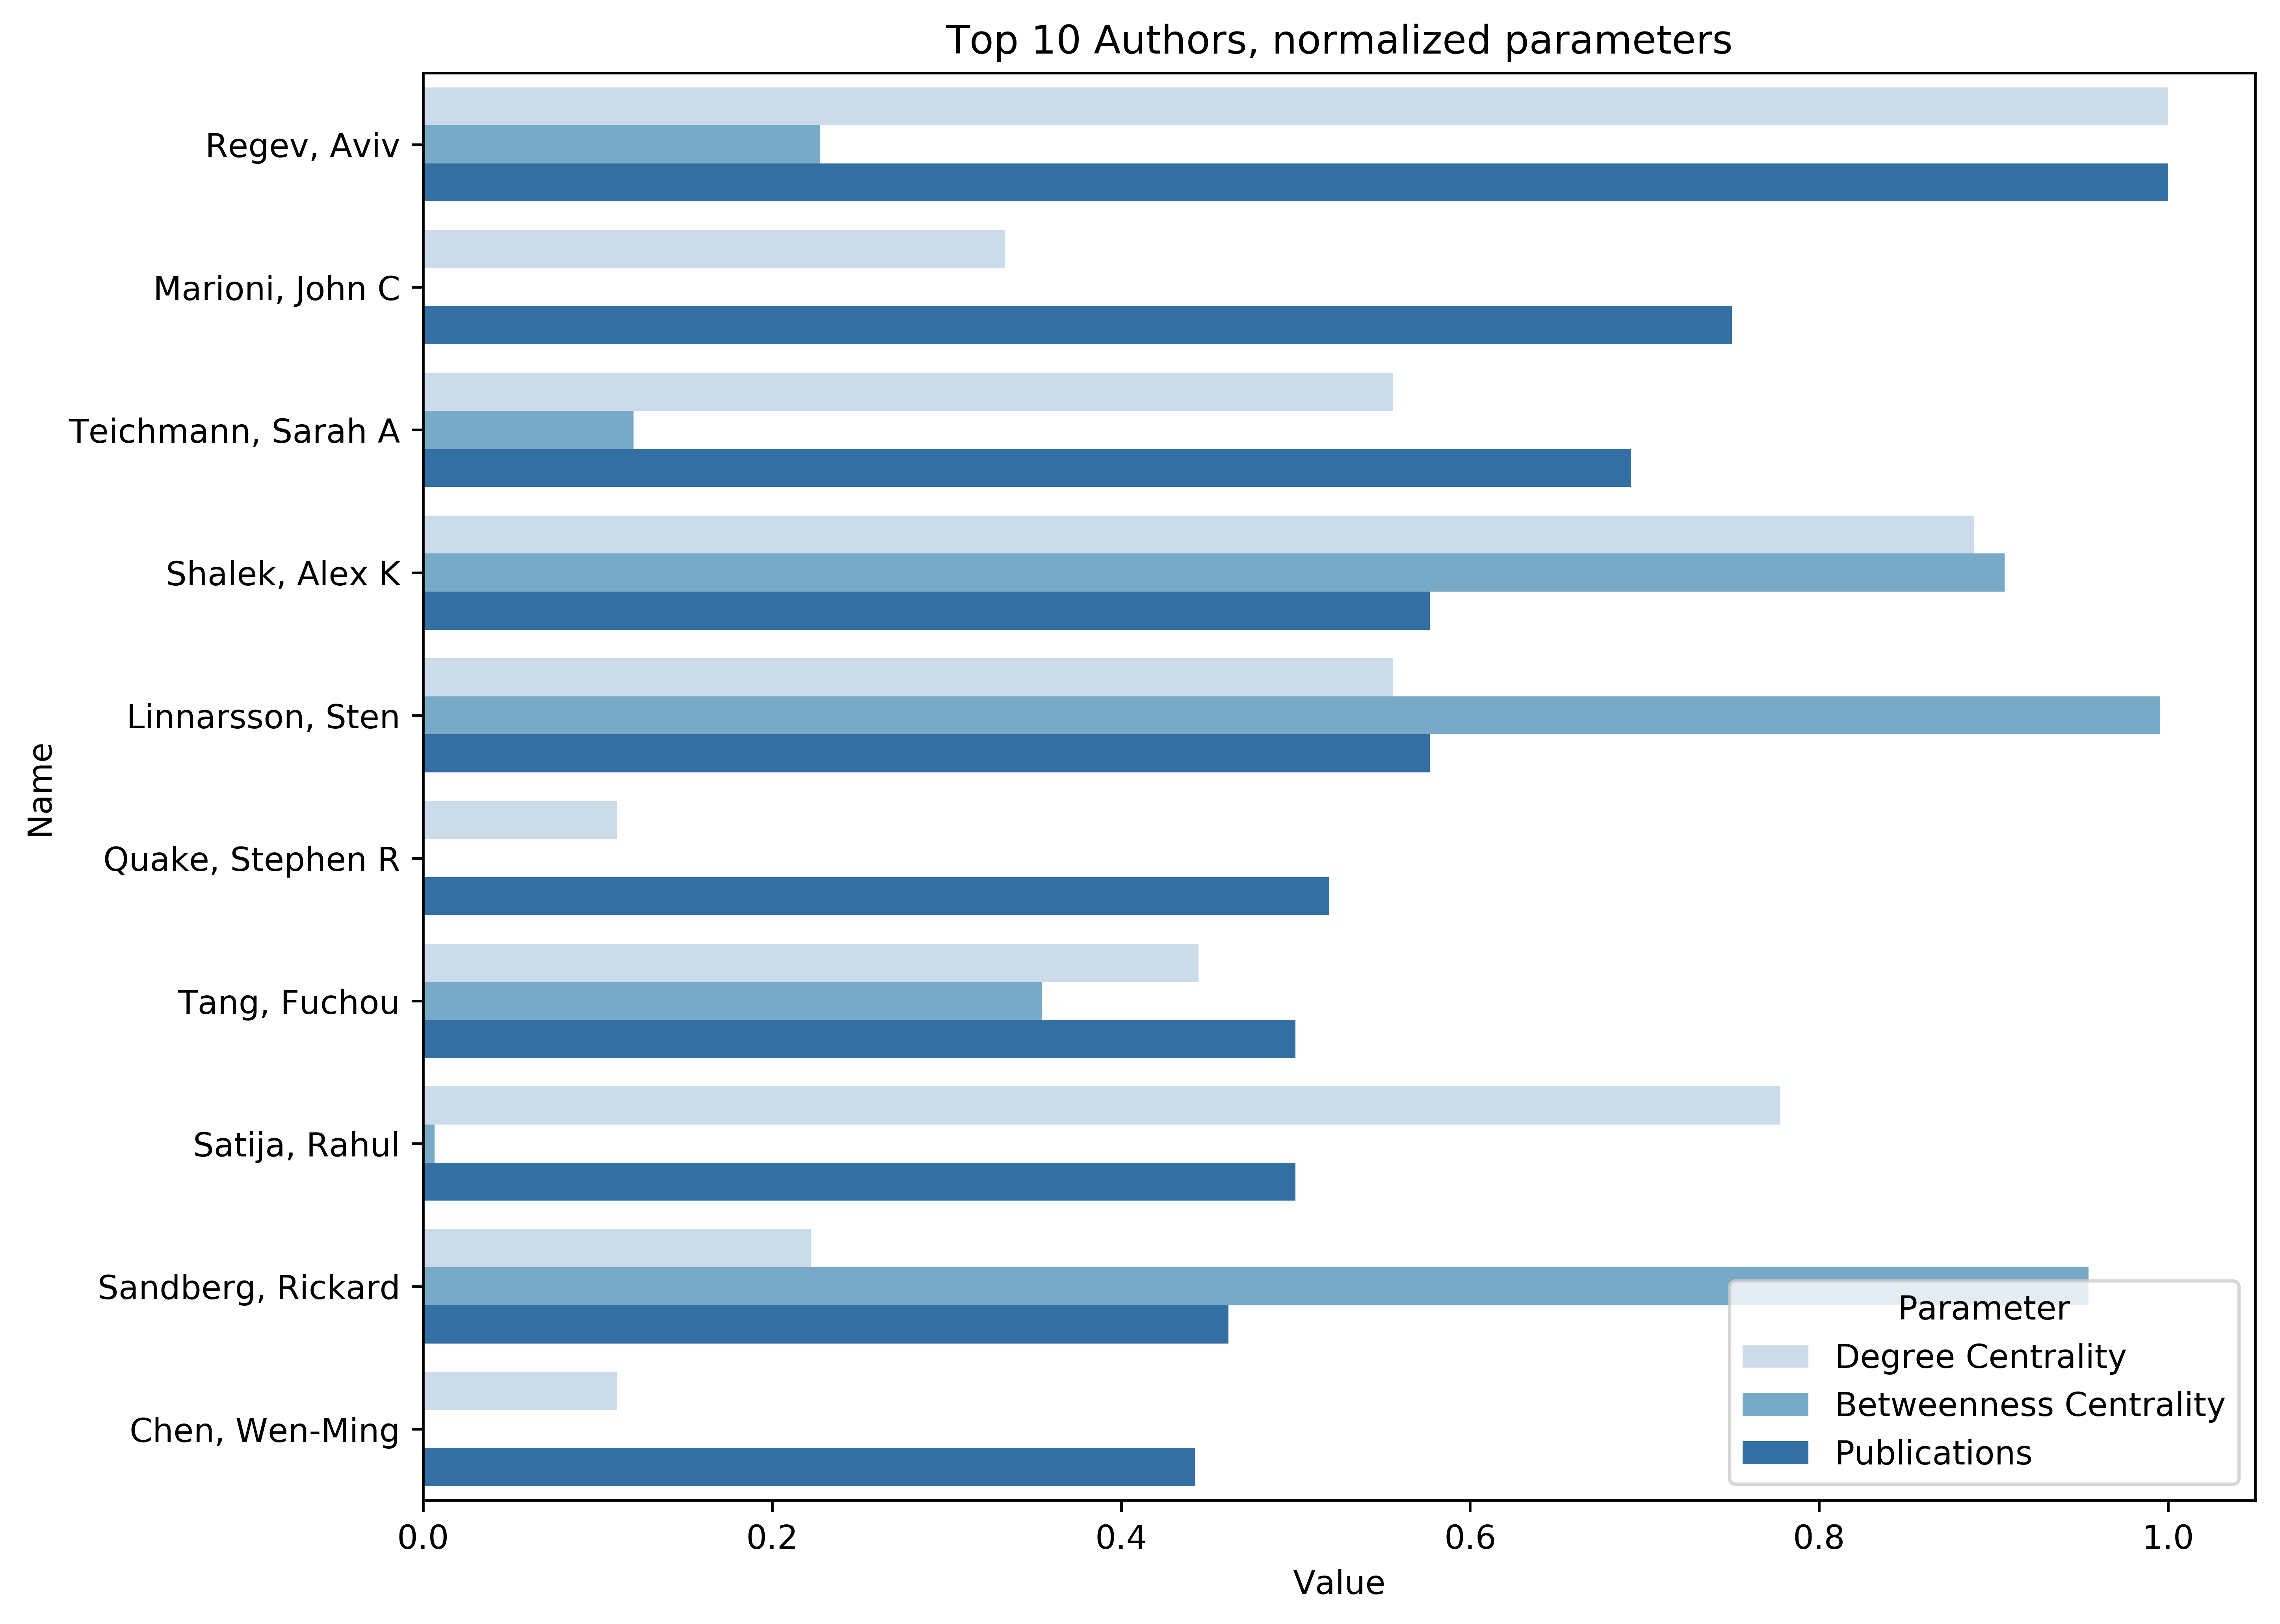

In [87]:
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()

We find that most of the top authors have pretty similar values for degree centrality, even after normalizing for their number of publications. This just means that most authors have a similar number of average total authors on their publications.

Meanwhile the authors sometimes differ greatly in their normalized betweenness centrality. "Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes" (https://en.wikipedia.org/wiki/Centrality#Betweenness_centrality). So here, a high betweenness centrality compared to degree centrality would mean that an individual has been on a lot of papers with pairs of people who are not directly connected. While a lower normalized betweeness centrality suggests that a lot of the people they are connected to are also connected to each other. Perhaps because they are all in the same lab or work together in some other kind of ongoing collaborative structure.

## Conclusions

Network analysis and text mining are two very useful techniques for getting a sense of a scientific field of research. While Maximillian Straub's work focused on this from an outsider's perspective, it was interesting to try applying these techniques to a topic where we already had some background knowledge.

Future directions might expand on the text mining section, including a comparison to other topics.